<a href="https://colab.research.google.com/github/Priyanshu14G/Intrusion_detection/blob/main/AI_Powered_Intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Update the path where the dataset is stored in Google Drive
dataset_path = "/content/drive/MyDrive/CICIDS2017.csv"


In [ ]:
df = pd.read_csv(dataset_path)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
print(df.columns)  # List all column names


Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [ ]:
df.columns = df.columns.str.strip()  # Remove spaces

In [ ]:
print(df.columns)  # Confirm that 'Label' exists correctly

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

PROCESSING AND FEATURE ENGINEERING & LABEL ENCODING

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset (ensure this is uncommented when running)
# df = pd.read_csv("your_dataset.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert Timestamp to datetime format
if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Drop unnecessary columns
df = df.drop(["Flow ID"], axis=1, errors='ignore')

# Handle missing/infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)  # Replace NaN only in numeric columns

# ---- Feature Engineering ---- #

# 1. **Packet Entropy Calculation**
def calculate_entropy(packet_sizes):
    value, counts = np.unique(packet_sizes, return_counts=True)
    probabilities = counts / len(packet_sizes)
    return -np.sum(probabilities * np.log2(probabilities))

if "Packet_Size" in df.columns:
    df["Packet_Entropy"] = df["Packet_Size"].rolling(5).apply(calculate_entropy, raw=True)

# 2. **Request Frequency (Requests per Second)**
if {"Source_IP", "Timestamp"}.issubset(df.columns):
    df["Request_Frequency"] = df.groupby("Source_IP")["Timestamp"].diff().dt.total_seconds().fillna(0)

# 3. **Unusual Device Behavior (Z-score normalization)**
if {"Device_ID", "Packet_Size"}.issubset(df.columns):
    df["Unusual_Device_Behavior"] = df.groupby("Device_ID")["Packet_Size"].transform(lambda x: (x - x.mean()) / x.std())

# ---- Label Encoding ---- #
if any(col.lower() == "label" for col in df.columns):
    le = LabelEncoder()
    df["Label"] = le.fit_transform(df["Label"])

    # Convert non-numeric columns to numeric (coercing errors)
    df = df.apply(pd.to_numeric, errors="coerce")

    # Normalize numerical features
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.drop(["Label"], axis=1))

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(df_scaled, df["Label"], test_size=0.2, random_state=42)

    print("Preprocessing completed successfully!")
else:
    raise KeyError("The column 'Label' is missing even after stripping spaces!")

# Display first few rows
df.head()



Preprocessing completed successfully!


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


MODEL TRAINING

A TRAIN LSTM FOR SEQUENTIAL ANOMLY DETECTION

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Reshape input for LSTM: (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define model (using GRU instead of LSTM for speed improvement)
model = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Faster than LSTM
    GRU(16, return_sequences=False),  # Reduce units for speed
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent unnecessary training
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train model
model.fit(X_train_reshaped, y_train, epochs=3, batch_size=32,
          validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

print("Training completed!")



Epoch 1/3
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 542s 94ms/step - accuracy: 0.8656 - loss: 0.2586 - val_accuracy: 0.9773 - val_loss: 0.0721
Epoch 2/3
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 484s 86ms/step - accuracy: 0.9750 - loss: 0.0786 - val_accuracy: 0.9758 - val_loss: 0.0814
Epoch 3/3
5644/5644 ━━━━━━━━━━━━━━━━━━━━ 480s 85ms/step - accuracy: 0.9745 - loss: 0.0857 - val_accuracy: 0.9838 - val_loss: 0.0604
Training completed!


Train GNN for Network Attack Propagation

In [ ]:
import os
os.system('pip install torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html')


0

In [ ]:
!pip install torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu121.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu121.html


In [ ]:
import torch_geometric
print("PyTorch Geometric installed successfully!")



/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

PyTorch Geometric installed successfully!


In [ ]:
import torch
import torch_geometric.nn as gnn
from torch_geometric.data import Data

# Ensure edge_index shape is correct (2, num_edges)
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)

# Example node features (4 nodes, 10 features each)
x = torch.rand((4, 10))

data = Data(x=x, edge_index=edge_index)
print(data)


Data(x=[4, 10], edge_index=[2, 4])


Train Autoencoder & Isolation Forest for Anomaly Detection

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.05)
iso_forest.fit(X_train)



IsolationForest(contamination=0.05)

Train Random Forest & XGBoost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Figure size 640x480 with 0 Axes>

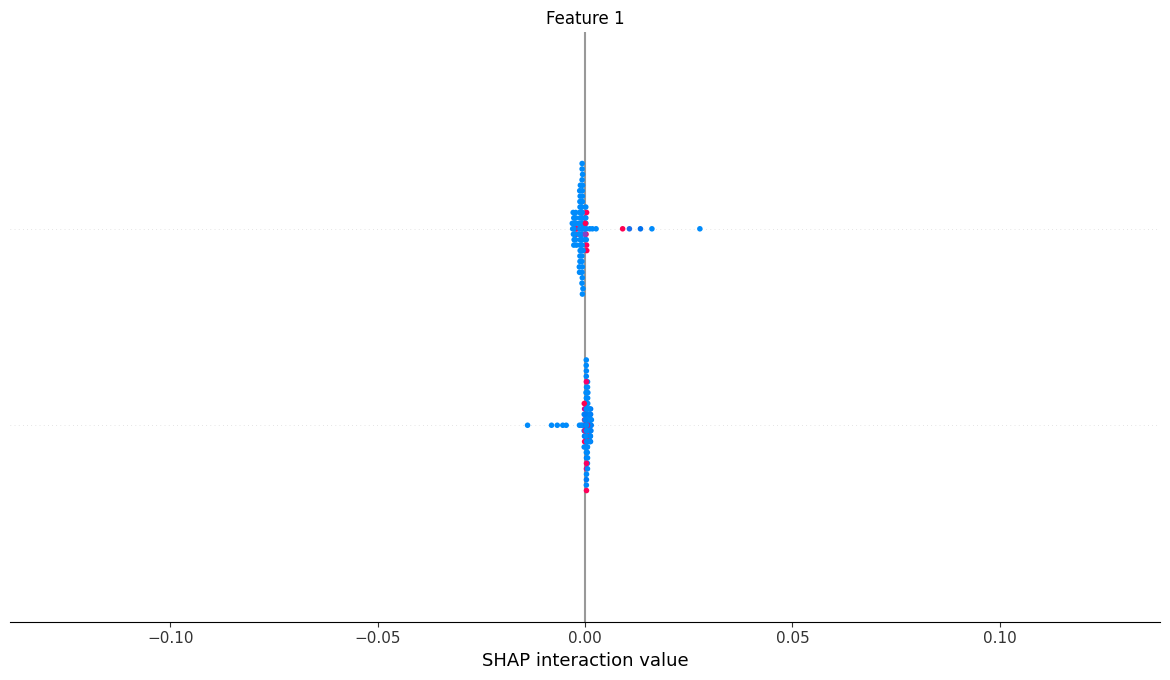

In [ ]:
import shap
import numpy as np

# Ensure feature consistency
assert X_train.shape[1] == X_test.shape[1], "Feature count mismatch"

# Handle missing values in NumPy array
X_test = np.where(np.isnan(X_test), np.nanmean(X_train, axis=0), X_test)

# Use optimized SHAP explainer
explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")

# Reduce test set size to speed up computation
sample_size = min(100, X_test.shape[0])  # Limit to 100 samples
X_test_sample = X_test[:sample_size]

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Visualize feature importance
shap.summary_plot(shap_values, X_test_sample)



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute False Positive Rate (FPR) & False Negative Rate (FNR)
FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"False Positive Rate: {FPR:.4f}")
print(f"False Negative Rate: {FNR:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


False Positive Rate: 0.0001
False Negative Rate: 0.0001
Accuracy: 0.9999
